# Introduction

Name        : Betara Candra 

Objective   : To detect bottle images, the images will be classified into several categories such as Beer bottles, Plastic bottles, Soda bottles, Water bottles and Wine bottles.

# Download File from Kaggle

In [2]:
from google.colab import files                                                            # Library to import file
!pip install -q kaggle
!wget https://raw.githubusercontent.com/betarac/dataset/main/kaggle.json -O kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

--2024-01-08 11:54:56--  https://raw.githubusercontent.com/betarac/dataset/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      63  --.-KB/s    in 0s      

2024-01-08 11:54:56 (4.33 MB/s) - ‘kaggle.json’ saved [63/63]

kaggle.json
total 4
-rw------- 1 root root 63 Jan  8 11:54 kaggle.json
{"username":"betarac","key":"d289c8ea3f3704ce6e7ef9eca195c6ad"}

In [3]:
pip install split-folders

In [4]:
!kaggle datasets download -d vencerlanz09/bottle-synthetic-images-dataset # Download dataset

 99% 1.25G/1.26G [00:12<00:00, 93.2MB/s]
100% 1.26G/1.26G [00:13<00:00, 104MB/s] 


In [5]:
!unzip -q /content/bottle-synthetic-images-dataset.zip                    # Unzip file

# I. Library

In [25]:
# Import Library
import numpy as np
import tensorflow as tf
from pathlib import Path
import glob
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
import os
import pickle

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import HeNormal

# II. Data Loading

In [7]:
# Define every class in folder
beer = glob.glob('/content/Bottle Images/Bottle Images/Beer Bottles/*')
plastic = glob.glob('/content/Bottle Images/Bottle Images/Plastic Bottles/*')
soda = glob.glob('/content/Bottle Images/Bottle Images/Soda Bottle/*')
water = glob.glob('/content/Bottle Images/Bottle Images/Water Bottle/*')
wine = glob.glob('/content/Bottle Images/Bottle Images/Wine Bottle/*')

# III. Exploratory Data Analysis (EDA)

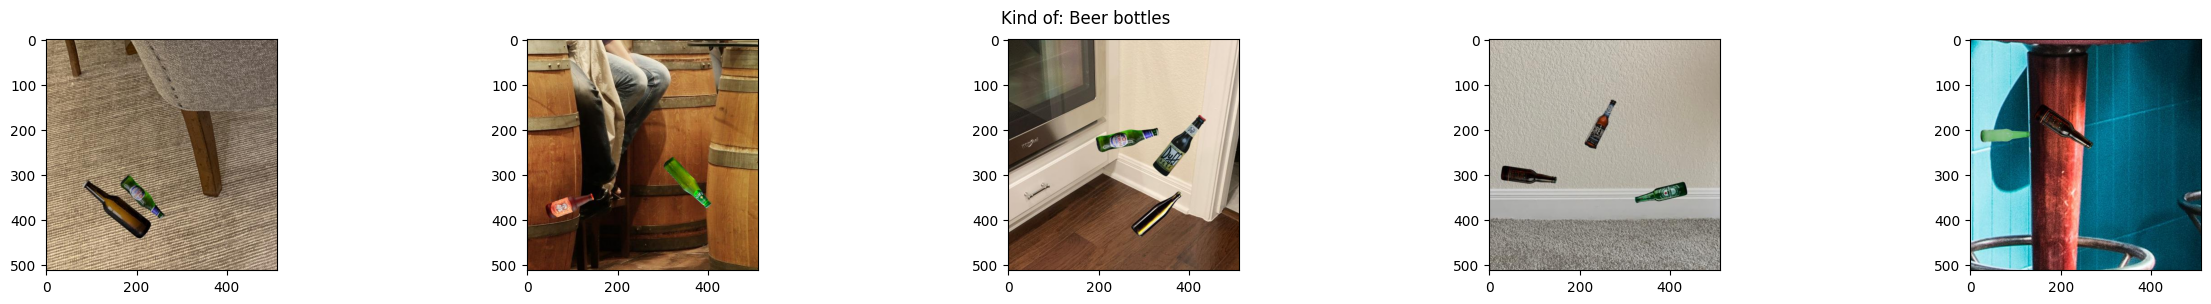

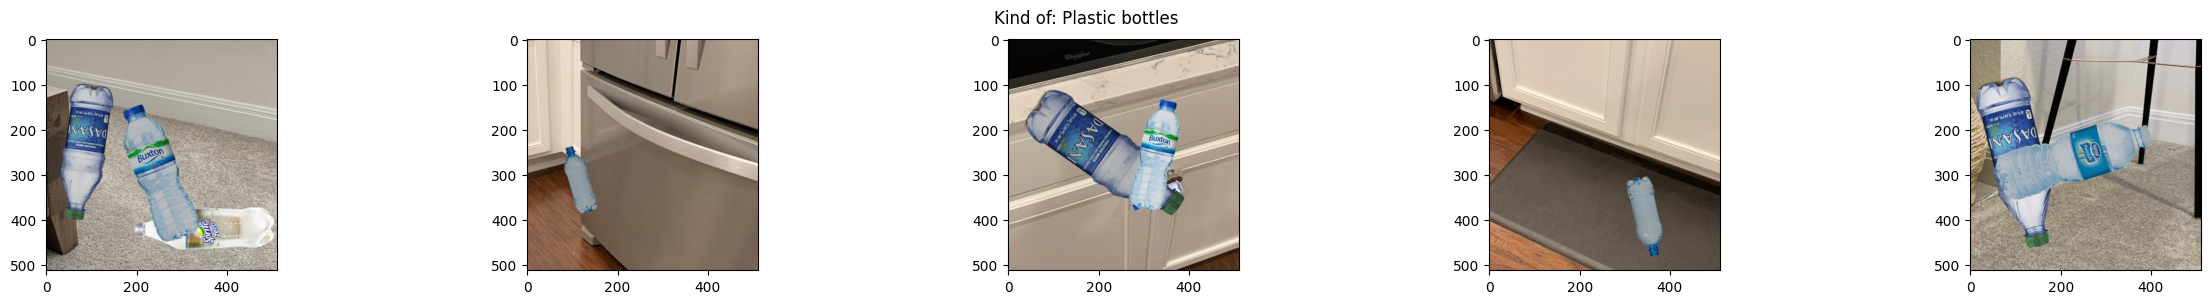

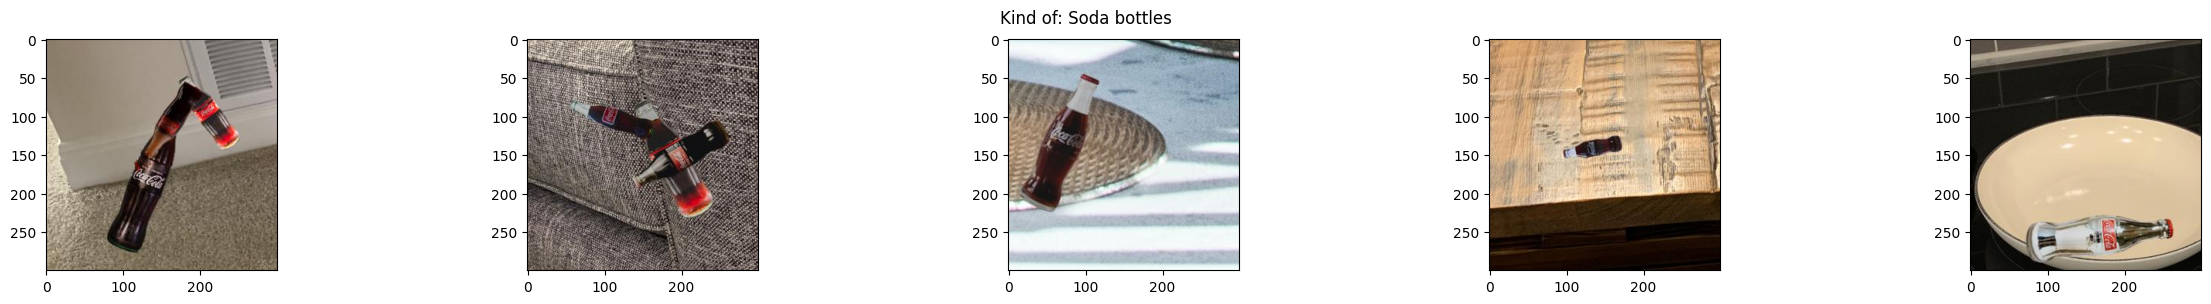

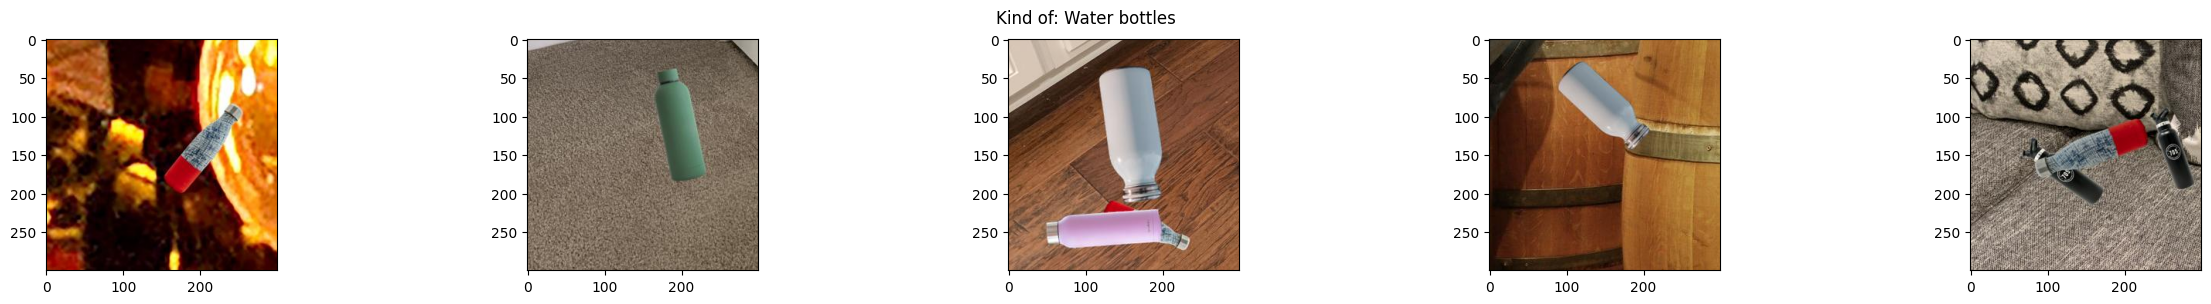

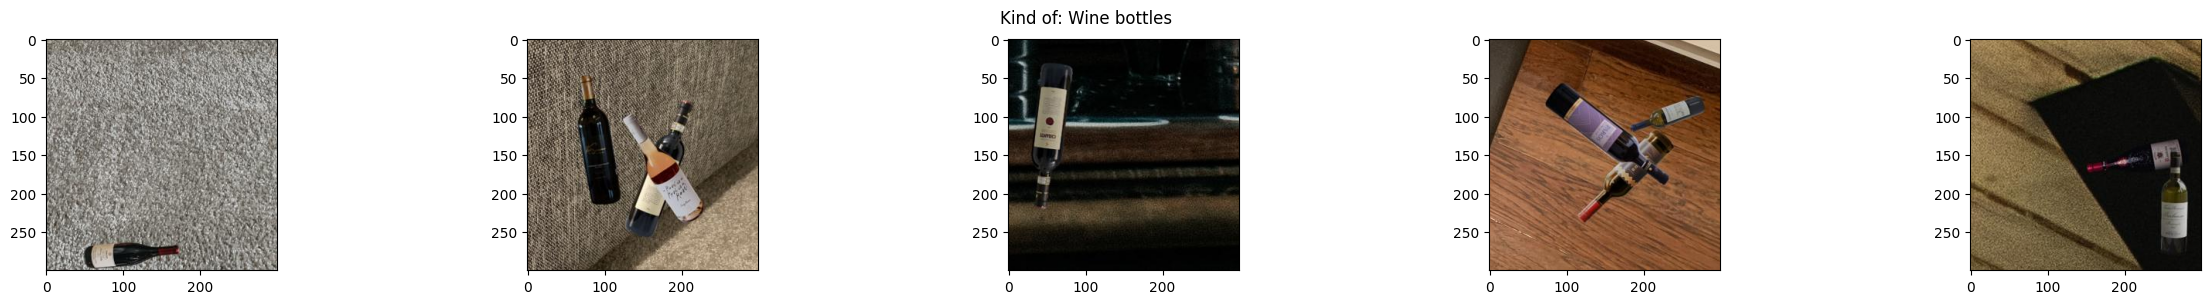

In [8]:
def vizual(jenis,title):                            # Function to show Images
  fig,ax = plt.subplots(ncols=5,figsize=(30,3))
  for i in range(5):
    pltshow = plt.imread(jenis[i])
    ax[i].imshow(pltshow)
  fig.suptitle(f'Kind of: {title} bottles')
  plt.show()
vizual(beer,"Beer")
vizual(plastic,'Plastic')
vizual(soda,'Soda')
vizual(water,'Water')
vizual(wine,'Wine')

This show that datase have 5 class, it's like

- Beer bottles
- Plastic bottles
- Soda bottles
- Water bottles
- Wine bottles

# IV. Feature Engineering

## 1. Data Splitting

In [9]:
path = '/content/Bottle Images/Bottle Images'                                       # Define path about classifiication data
splitfolders.ratio(path,seed=1337, output="Bottles-Splited", ratio=(0.6, 0.2,0.2))      # Split dataset into train, test and val

Copying files: 25000 files [00:05, 4778.93 files/s]


In [10]:
# Change scale form 1 - 255 or grayscale
train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

train_gen = train_datagen.flow_from_directory(
    "/content/Bottles-Splited/train",
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 126,
    shuffle =False
)
val_gen = train_datagen.flow_from_directory(
    "/content/Bottles-Splited/train",
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 126,
    shuffle =False
)
test_gen = test_datagen.flow_from_directory(
    "/content/Bottles-Splited/val",
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 126,
    shuffle =False
)

Found 15000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


This dataset it's split into train,val and test. In train and val it's can see there are about 15000 images belonging 5 classes. In test it's found 5000 images belonging to 5 classes

In [11]:
# Define class that dataset have
print(train_gen.class_indices)
print (val_gen.class_indices)
print(test_gen.class_indices)

{'Beer Bottles': 0, 'Plastic Bottles': 1, 'Soda Bottle': 2, 'Water Bottle': 3, 'Wine Bottle': 4}
{'Beer Bottles': 0, 'Plastic Bottles': 1, 'Soda Bottle': 2, 'Water Bottle': 3, 'Wine Bottle': 4}
{'Beer Bottles': 0, 'Plastic Bottles': 1, 'Soda Bottle': 2, 'Water Bottle': 3, 'Wine Bottle': 4}


The datase have beer,plastic,soda,water, and wine class

# V. Model

## 1. Model Baseline

### 1.1 Model Definition

In [12]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
# Use Sequential API
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))                                 # softmax for classification

In [14]:
model.summary()

# Model Compile
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

It's model define a neaural network with 5 connected layer with layer has 512 neuron with ReLU activation. The model compile use with adam optimizer and categorical_crossentropy

### 1.2 Model Training

In [15]:
# Training data with sequential
%%time
history = model.fit(train_gen, epochs=25, validation_data = val_gen, verbose = 1, validation_steps=10)

Epoch 1/25
120/120 [==============================] - 46s 313ms/step - loss: 1.6254 - accuracy: 0.2071 - val_loss: 1.6912 - val_accuracy: 0.0000e+00
Epoch 2/25
120/120 [==============================] - 37s 312ms/step - loss: 1.6089 - accuracy: 0.2517 - val_loss: 1.6273 - val_accuracy: 0.0000e+00
Epoch 3/25
120/120 [==============================] - 36s 303ms/step - loss: 1.5976 - accuracy: 0.2698 - val_loss: 1.5262 - val_accuracy: 0.0016
Epoch 4/25
120/120 [==============================] - 34s 282ms/step - loss: 1.5622 - accuracy: 0.2994 - val_loss: 1.4419 - val_accuracy: 0.5722
Epoch 5/25
120/120 [==============================] - 38s 317ms/step - loss: 1.5567 - accuracy: 0.2788 - val_loss: 1.4208 - val_accuracy: 0.7540
Epoch 6/25
120/120 [==============================] - 36s 296ms/step - loss: 1.4834 - accuracy: 0.3076 - val_loss: 1.7466 - val_accuracy: 0.0254
Epoch 7/25
120/120 [==============================] - 35s 294ms/step - loss: 1.4715 - accuracy: 0.3125 - val_loss: 1.4908 

### 1.3 Model Evaluation

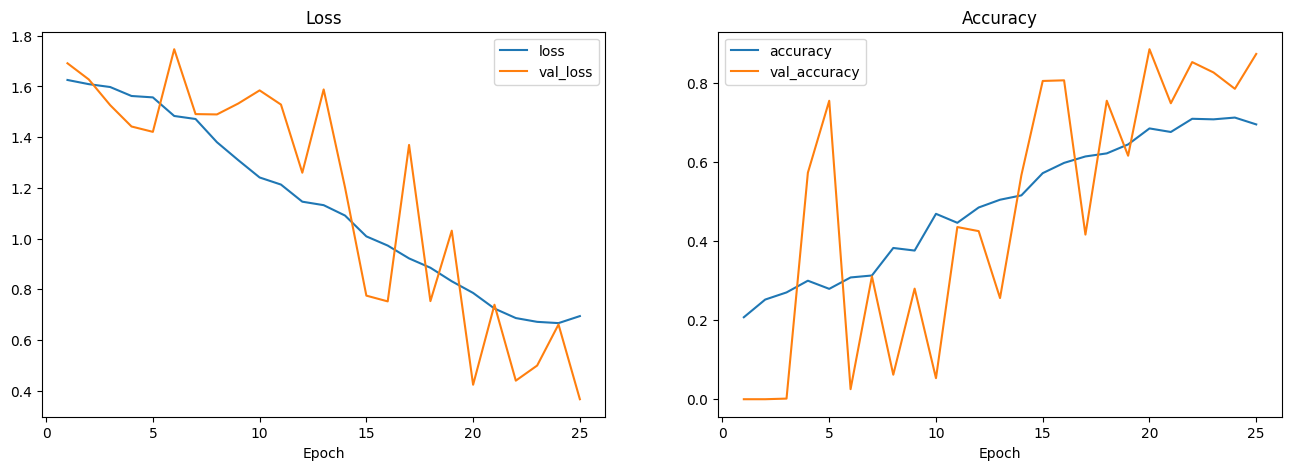

In [17]:

# Plot result val and train set
epoch=25

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

This model show that loss of train and vall are decrease. The accuracy show that increase and good fit, but the val_accuracy have bigger accuracy with train

## 2. Model Improve

### 2.1 Model Definition

In [40]:
# Augmentasi data
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

In [37]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [38]:
# Use Sequential API
model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.GlobalAveragePooling2D())
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(512, activation='relu'))
model1.add(tf.keras.layers.Dense(5, activation='softmax'))                                 # softmax for classification
# Model Compile
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                        

It's model define a neaural network with 5 connected layer with layer has 512 neuron with ReLU activation. The model compile use with adam optimizer and categorical_crossentropy

## 2.2 Model Training

In [45]:

# Define Callback
%%time
checkpoint = ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True,
                            mode='max',
                            verbose=1)
history = model1.fit(train_gen ,epochs=30, validation_data=val_gen, callbacks=[checkpoint])

Epoch 1/30
120/120 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9759
Epoch 1: val_loss improved from -inf to 2.44515, saving model to best_model.h5
120/120 [==============================] - 73s 607ms/step - loss: 0.0948 - accuracy: 0.9759 - val_loss: 2.4452 - val_accuracy: 0.2829
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9702
Epoch 2: val_loss improved from 2.44515 to 2.76825, saving model to best_model.h5
120/120 [==============================] - 61s 507ms/step - loss: 0.1025 - accuracy: 0.9702 - val_loss: 2.7683 - val_accuracy: 0.2889
Epoch 3/30
120/120 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9516
Epoch 3: val_loss did not improve from 2.76825
120/120 [==============================] - 61s 509ms/step - loss: 0.1480 - accuracy: 0.9516 - val_loss: 2.4301 - val_accuracy: 0.2920
Epoch 4/30
120/120 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9809
Epoch 4: val_loss did not improve from 2.76825
120/120 [==============================] - 60s 500ms/step - loss: 0.0832 - accuracy: 0.9809 - val_loss: 2.6927 - val_accuracy: 0.2939
Epoch 5/30
120/120 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9709
Epoch 5: val_loss improved from 2.76825 to 2.8839

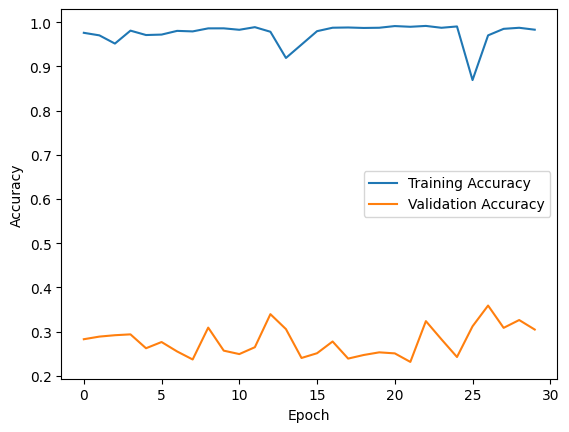

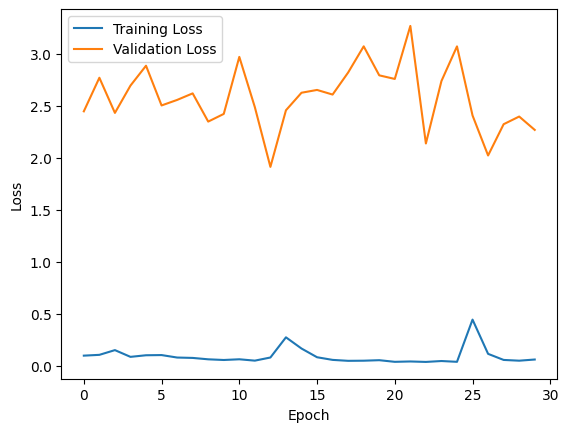

In [47]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In improve i try to add epoch in 30, i hope the model is overfitt. And i use Batch normalization for applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. From checkpoint that use to quickly recover from such failures to reduce the overall training time and ensure progress

# VIII. Model Saving

Model is already saving in training improvement

# IX. Model Predict

In [52]:
# Define class
label_names = ["Beer Bottles", "Plastic Bottles", "Soda Bottles",'Water Bottle','Wine Bottle']

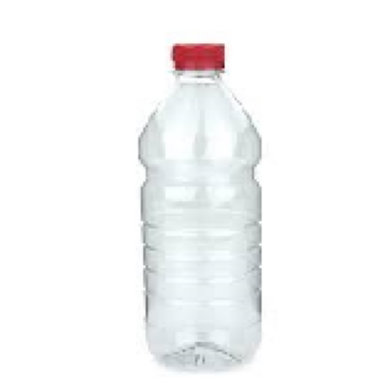

1/1 [==============================] - 0s 21ms/step
Predicted Class: Water Bottle


In [58]:
# Load the image
image_path = '/content/botol.jpg'
img = tf.keras.utils.load_img(image_path, target_size=(150, 150, 3))

# Preprocess the image
image_size = (150, 150)
image = img.resize(image_size)

# Convert image to a numpy array
image_array = np.array(image)

# Normalize the image data if needed
image_array = image_array / 255.0

# Expand dimensions to create a batch of size 1
image_array = np.expand_dims(image_array, axis=0)

# Display the image
plt.imshow(image_array[0])
plt.axis('off')  # Hide axes
plt.show()

# Predict data
y_pred = model1.predict(image_array)

# Get index predicted class
predicted_class = np.argmax(y_pred, axis=1)[0]

print(f"Predicted Class: {label_names[predicted_class]}")


# X. Conclusion

## About Dataset

This dataset is belonging to 5 classes, there are beer,plastic,soda, water, and wine. 35000 data of image that are split in train, val and test. And the data are size image in (150,150,3).

## Model

For baseline model it's show a good fit, but the val is bigger than a train. 0.69 in train, 0.87 in val accuracy. But the improve show the train is in 1.0, val test is bad. It's mean so overfit. In improve i use flatten to take only one demensional input, because i want to insert this Pooled Feature map into Neural Network and Neural Network can take only One Dimensional input

For improve model again, that can be search by improve the layer of model or resize the image to predict. Data augmentation is need for improvement, cause it's can be predict ambiguous image position